# ML Trading System - Interaktiv Debug Notebook

Detta notebook ger dig kraftfulla verktyg för att debugga och analysera ML trading systemet med visualiseringar istället för konsol-utskrifter.

## 1. Setup och Konfiguration

In [1]:
# Sätt FRED API nyckel och importera bibliotek
import os
os.environ['FRED_API_KEY'] = '8d9ad11bf6016ba0a68f2f6f56f056ba'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Konfigurera plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

print("✅ Setup klart!")

✅ Setup klart!


## 2. Ladda och Analysera Rådata

In [2]:
# Ladda data och bygg features
from src.fetch_data import fetch_sp500_from_fred
from src.features import build_feature_set
from src.labels import make_std_labels
from src.config import LABEL_HORIZON

print("🔄 Laddar S&P 500 data...")
df_raw = fetch_sp500_from_fred(start="2000-01-01")

print("🔄 Bygger features...")
df_features = build_feature_set(df_raw)

print("🔄 Skapar labels...")
df_labeled = make_std_labels(df_features, horizon=LABEL_HORIZON)

# Feature kolumner
exclude = {"Date","Close","label","fwd_return","vol_h"}
feature_cols = [c for c in df_labeled.columns if c not in exclude]

print(f"✅ Data laddad:")
print(f"  - Rådata shape: {df_raw.shape}")
print(f"  - Efter features: {df_features.shape}")
print(f"  - Efter labels: {df_labeled.shape}")
print(f"  - Antal features: {len(feature_cols)}")
print(f"  - Datum range: {df_raw['Date'].min()} till {df_raw['Date'].max()}")

🔄 Laddar S&P 500 data...
🔄 Bygger features...
🔄 Skapar labels...
✅ Data laddad:
  - Rådata shape: (2515, 2)
  - Efter features: (2515, 16)
  - Efter labels: (2515, 19)
  - Antal features: 14
  - Datum range: 2015-08-31 00:00:00 till 2025-08-29 00:00:00


## 3. Data Overview Visualisering

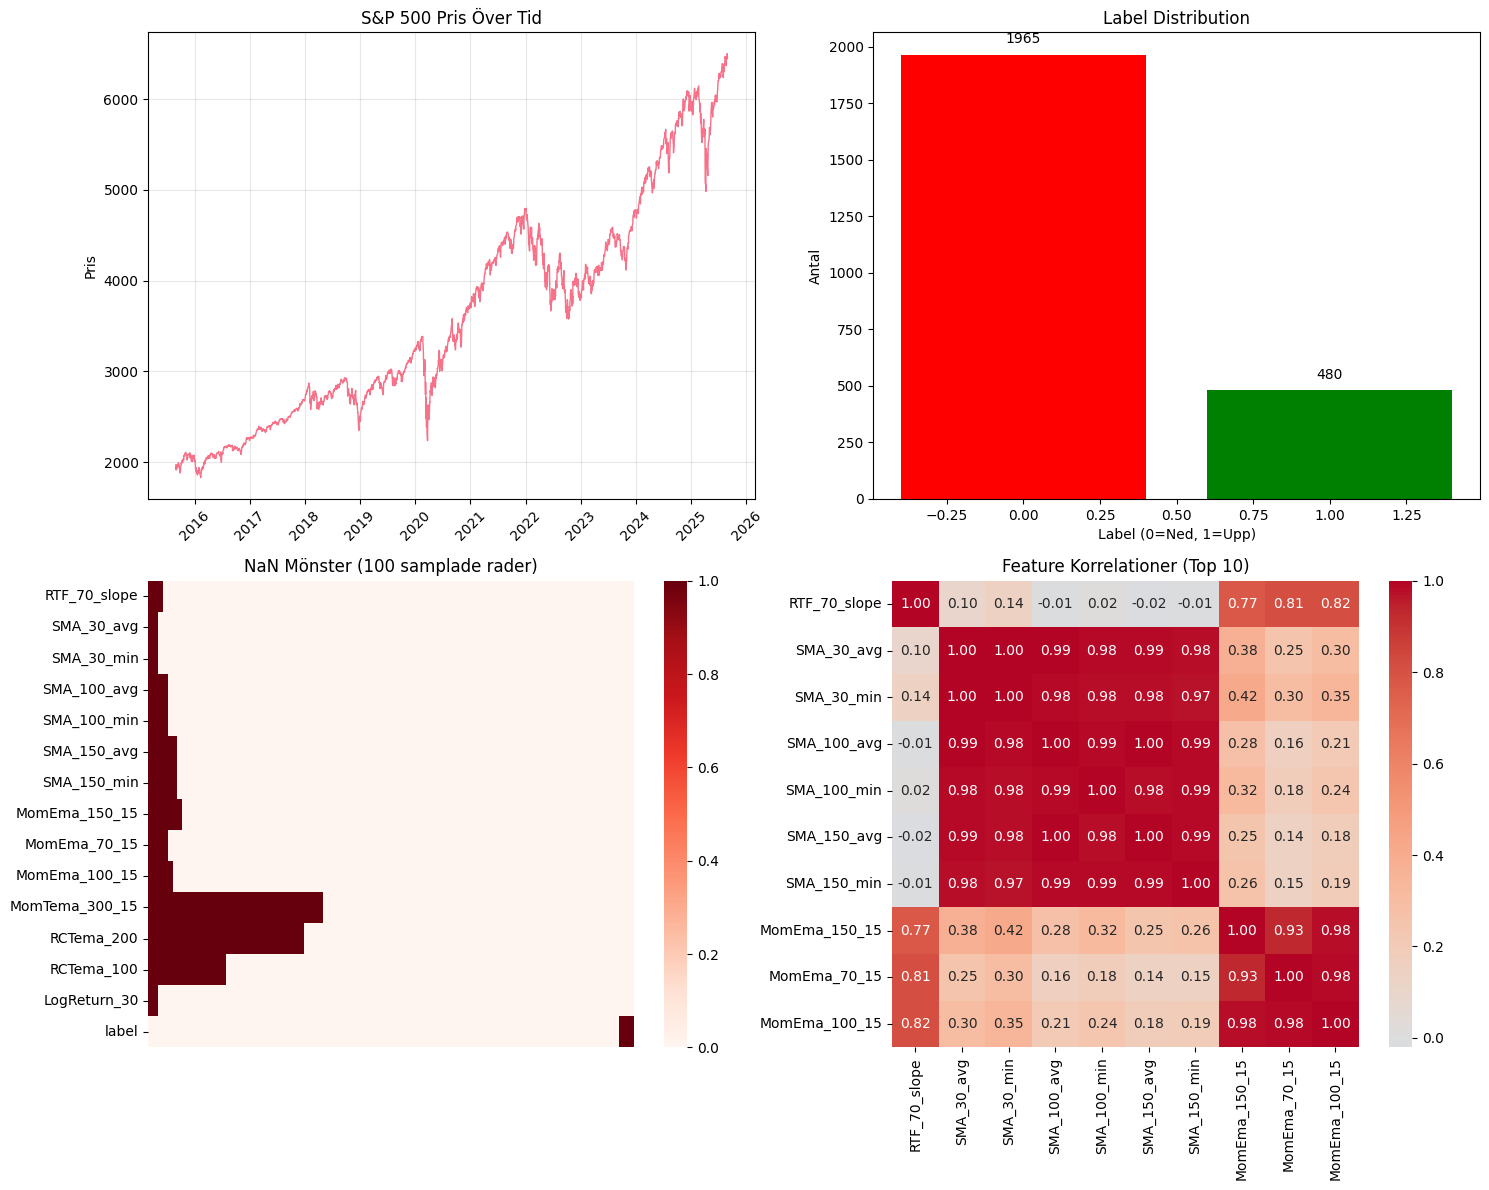

📊 Data kvalitet:
  - Label balans: {0.0: np.int64(1965), 1.0: np.int64(480)}
  - NaN per kolumn: 3121 totalt


In [3]:
# Skapa overview plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. S&P 500 pris över tid
axes[0,0].plot(pd.to_datetime(df_raw['Date']), df_raw['Close'], linewidth=1)
axes[0,0].set_title('S&P 500 Pris Över Tid')
axes[0,0].set_ylabel('Pris')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Label distribution
label_counts = df_labeled['label'].value_counts()
axes[0,1].bar(label_counts.index, label_counts.values, color=['red', 'green'])
axes[0,1].set_title('Label Distribution')
axes[0,1].set_xlabel('Label (0=Ned, 1=Upp)')
axes[0,1].set_ylabel('Antal')
for i, v in enumerate(label_counts.values):
    axes[0,1].text(i, v + 50, str(v), ha='center')

# 3. NaN mönster (sample)
nan_data = df_labeled[feature_cols + ['label']].isnull()
sample_indices = np.linspace(0, len(nan_data)-1, 100, dtype=int)
sns.heatmap(nan_data.iloc[sample_indices].T, ax=axes[1,0], cbar=True, 
           yticklabels=True, xticklabels=False, cmap='Reds')
axes[1,0].set_title('NaN Mönster (100 samplade rader)')

# 4. Feature korrelationer (sample av features)
sample_features = feature_cols[:10] if len(feature_cols) > 10 else feature_cols
corr_sample = df_labeled[sample_features].dropna().corr()
sns.heatmap(corr_sample, ax=axes[1,1], cmap='coolwarm', center=0,
           square=True, cbar=True, annot=True, fmt='.2f')
axes[1,1].set_title(f'Feature Korrelationer (Top {len(sample_features)})')

plt.tight_layout()
plt.show()

print(f"📊 Data kvalitet:")
print(f"  - Label balans: {dict(label_counts)}")
print(f"  - NaN per kolumn: {df_labeled[feature_cols].isnull().sum().sum()} totalt")

## 4. Detaljerad Feature Analys

In [4]:
# Feature statistik
feature_data = df_labeled[feature_cols]

# Skapa statistik DataFrame
stats = pd.DataFrame({
    'count': feature_data.count(),
    'mean': feature_data.mean(),
    'std': feature_data.std(),
    'min': feature_data.min(),
    'max': feature_data.max(),
    'nan_count': feature_data.isnull().sum(),
    'nan_pct': (feature_data.isnull().sum() / len(feature_data) * 100).round(2)
})

print("📈 FEATURE STATISTIK:")
display(stats.round(4))

📈 FEATURE STATISTIK:


,count,mean,std,min,max,nan_count,nan_pct
RTF_70_slope,2446,0.0322,0.0834,-0.3466,0.2751,69,2.74
SMA_30_avg,2486,3604.0162,1183.0996,1896.4517,6392.5660,29,1.15
SMA_30_min,2486,3460.7211,1136.8502,1829.0800,6238.0100,29,1.15
SMA_100_avg,2416,3590.1351,1137.9716,1993.6887,6016.6176,99,3.94
SMA_100_min,2416,3287.8764,1037.2777,1829.0800,5705.4500,99,3.94
SMA_150_avg,2366,3583.9599,1111.1976,1995.7426,5952.1893,149,5.92
SMA_150_min,2366,3203.7171,995.3436,1829.0800,5408.4200,149,5.92
MomEma_150_15,2351,25.5404,38.2997,-112.6907,95.5059,164,6.52
MomEma_70_15,2431,25.5122,56.8206,-235.1855,143.3603,84,3.34
MomEma_100_15,2401,25.6319,47.1487,-170.8505,115.7311,114,4.53


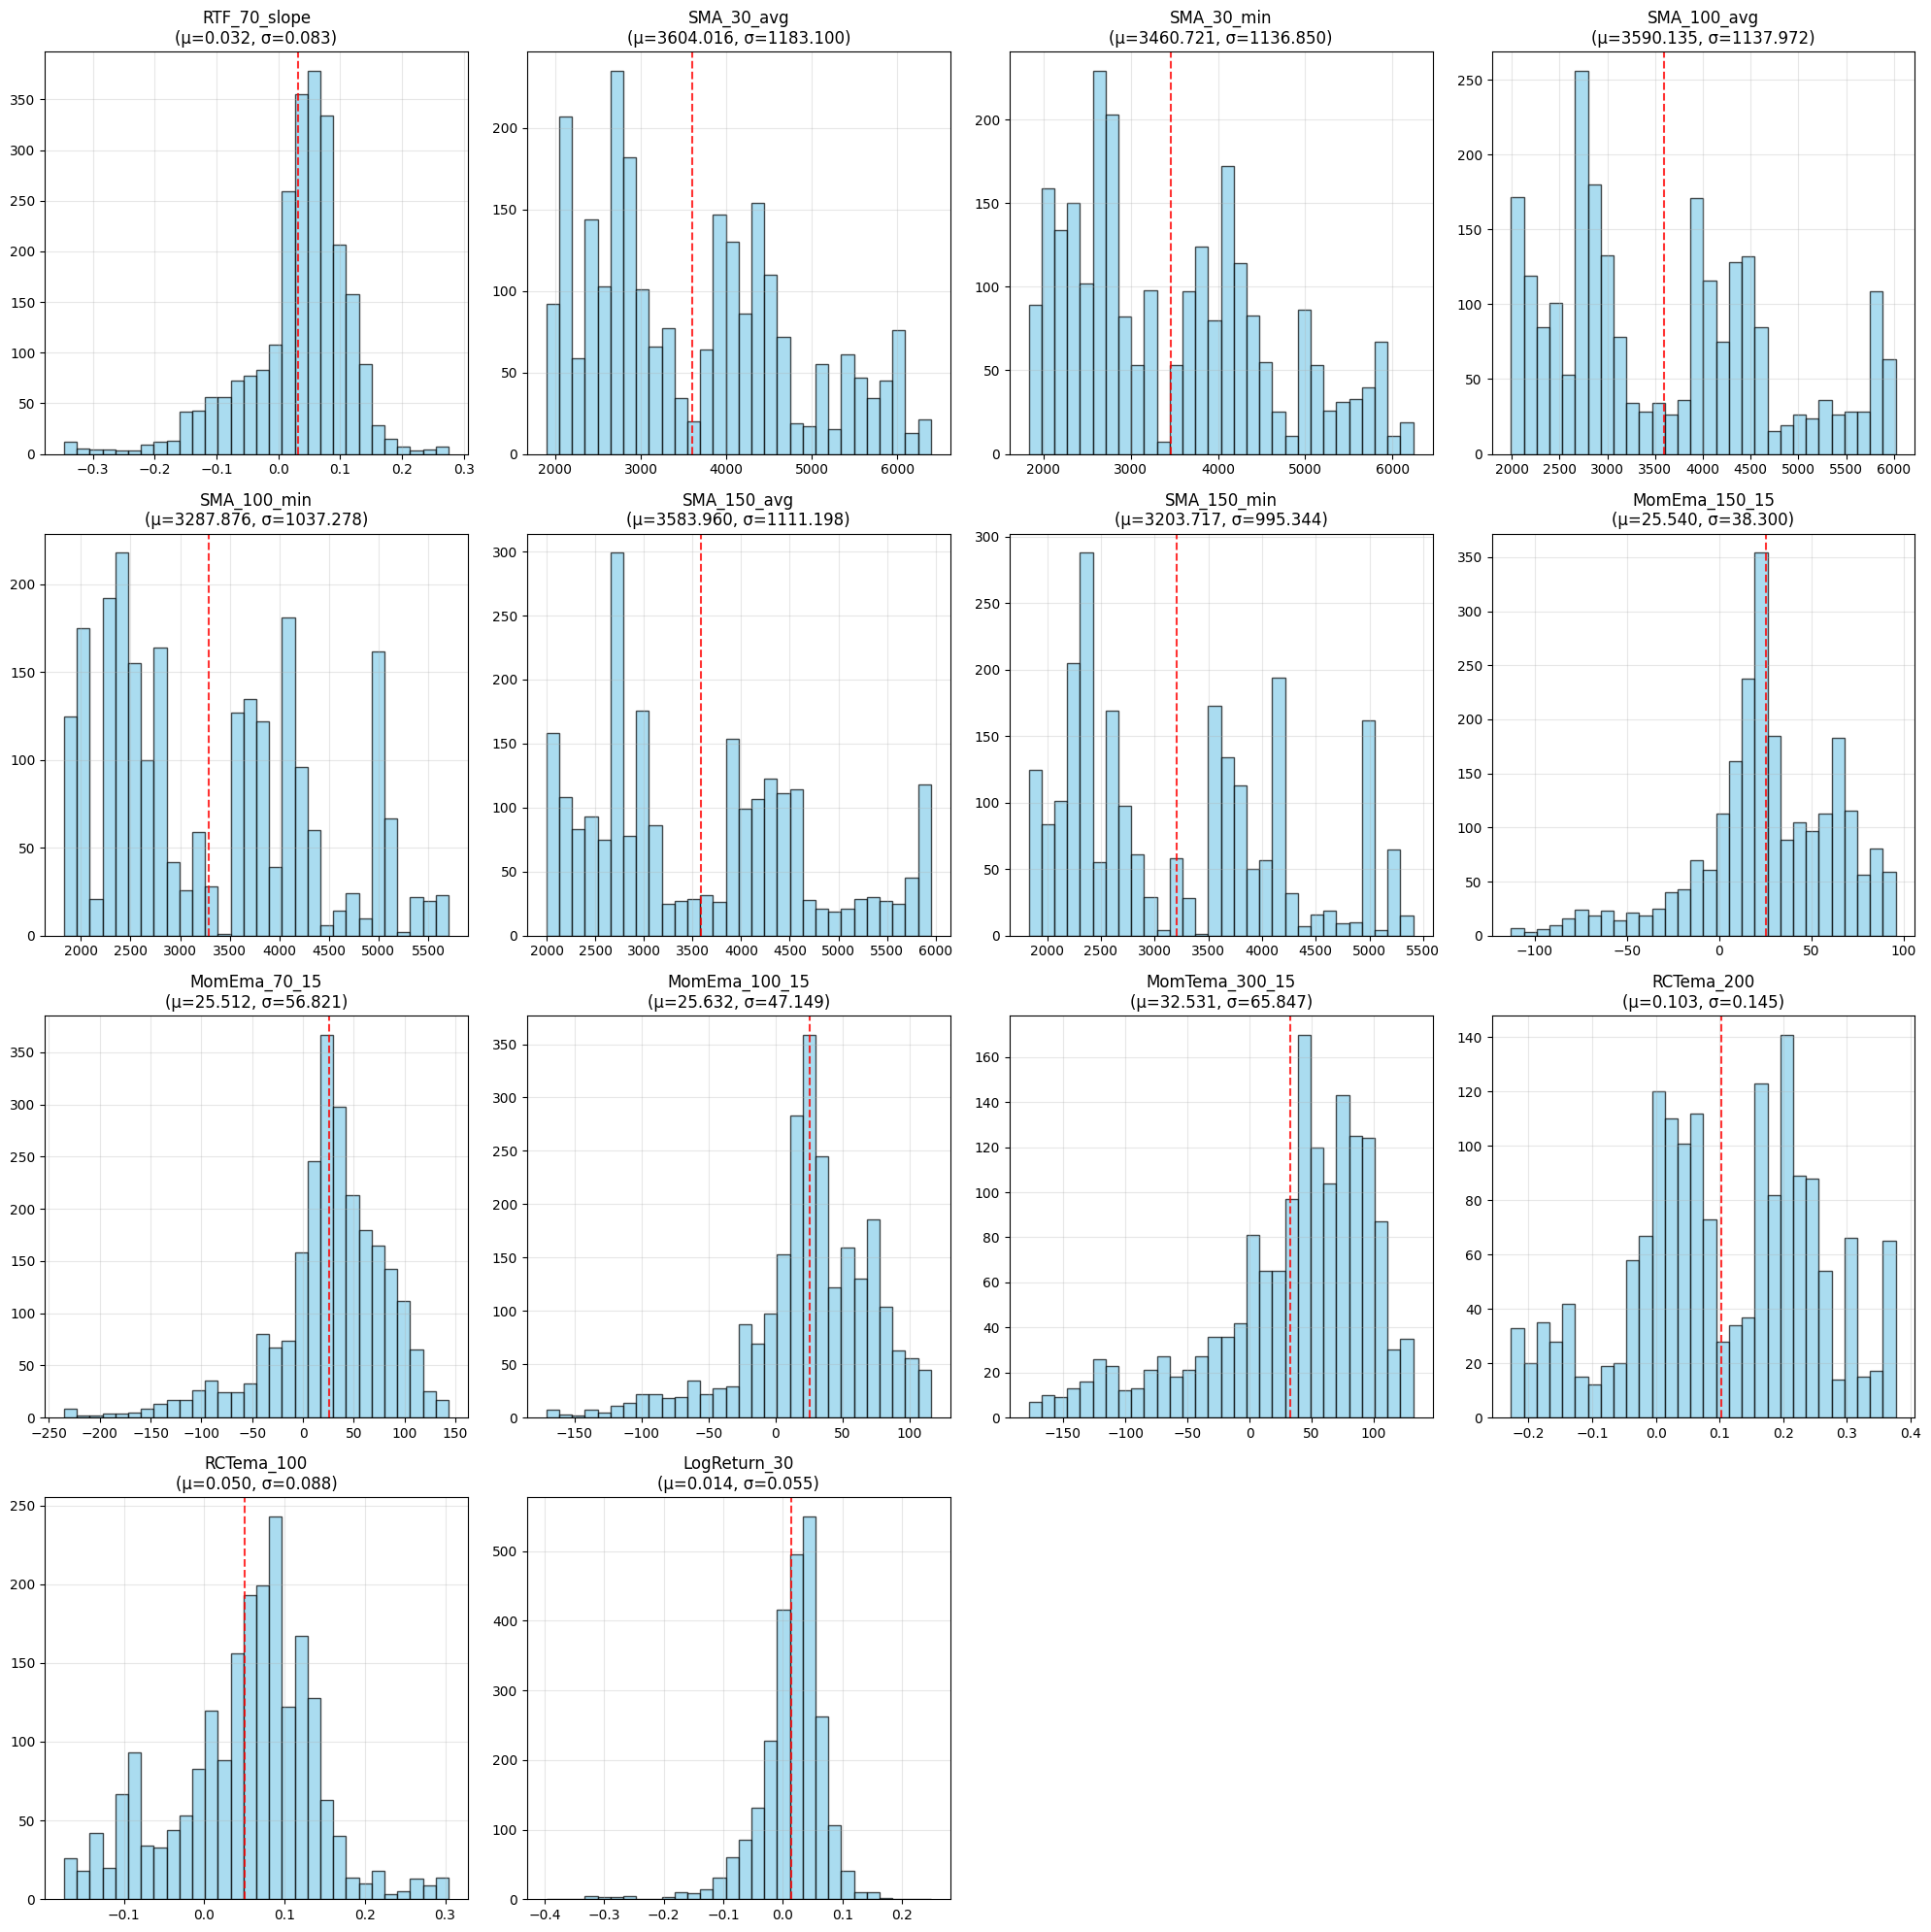

In [5]:
# Plot feature distributions
n_features = len(feature_cols)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, col in enumerate(feature_cols):
    if i < len(axes):
        data = feature_data[col].dropna()
        axes[i].hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col}\n(μ={data.mean():.3f}, σ={data.std():.3f})')
        axes[i].grid(True, alpha=0.3)
        axes[i].axvline(data.mean(), color='red', linestyle='--', alpha=0.8, label='Mean')

# Dölj onödiga subplots
for i in range(len(feature_cols), len(axes)):
    axes[i].set_visible(False)
    
plt.tight_layout()
plt.show()

## 5. ML Model Debug - Single Training

In [6]:
# Preparera data för ML debug
from src.model import make_mlp_bagging, fit_predict

print("🤖 SINGLE MODEL TRAINING DEBUG")
print("=" * 40)

# Ta clean data sample
df_clean = df_labeled.dropna(subset=feature_cols+["label"])
sample_size = min(2000, len(df_clean))
df_sample = df_clean.head(sample_size)

X = df_sample[feature_cols].values
y = df_sample["label"].values.astype(int)

print(f"📊 Sample info:")
print(f"  - Sample size: {X.shape}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Label distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
print(f"  - Feature matrix stats: min={X.min():.3f}, max={X.max():.3f}, mean={X.mean():.3f}")

# Split train/test
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\n🔄 Training model...")
clf = make_mlp_bagging()
y_pred, y_proba, trained_clf = fit_predict(clf, X_train, y_train, X_test)

# Beräkna metrics
accuracy = (y_pred == y_test).mean()
print(f"✅ Model tränad! Accuracy: {accuracy:.3f}")

🤖 SINGLE MODEL TRAINING DEBUG
📊 Sample info:
  - Sample size: (1533, 14)
  - Features: 14
  - Label distribution: {np.int64(0): np.int64(1237), np.int64(1): np.int64(296)}
  - Feature matrix stats: min=-235.185, max=6041.855, mean=1700.313

🔄 Training model...
✅ Model tränad! Accuracy: 0.580


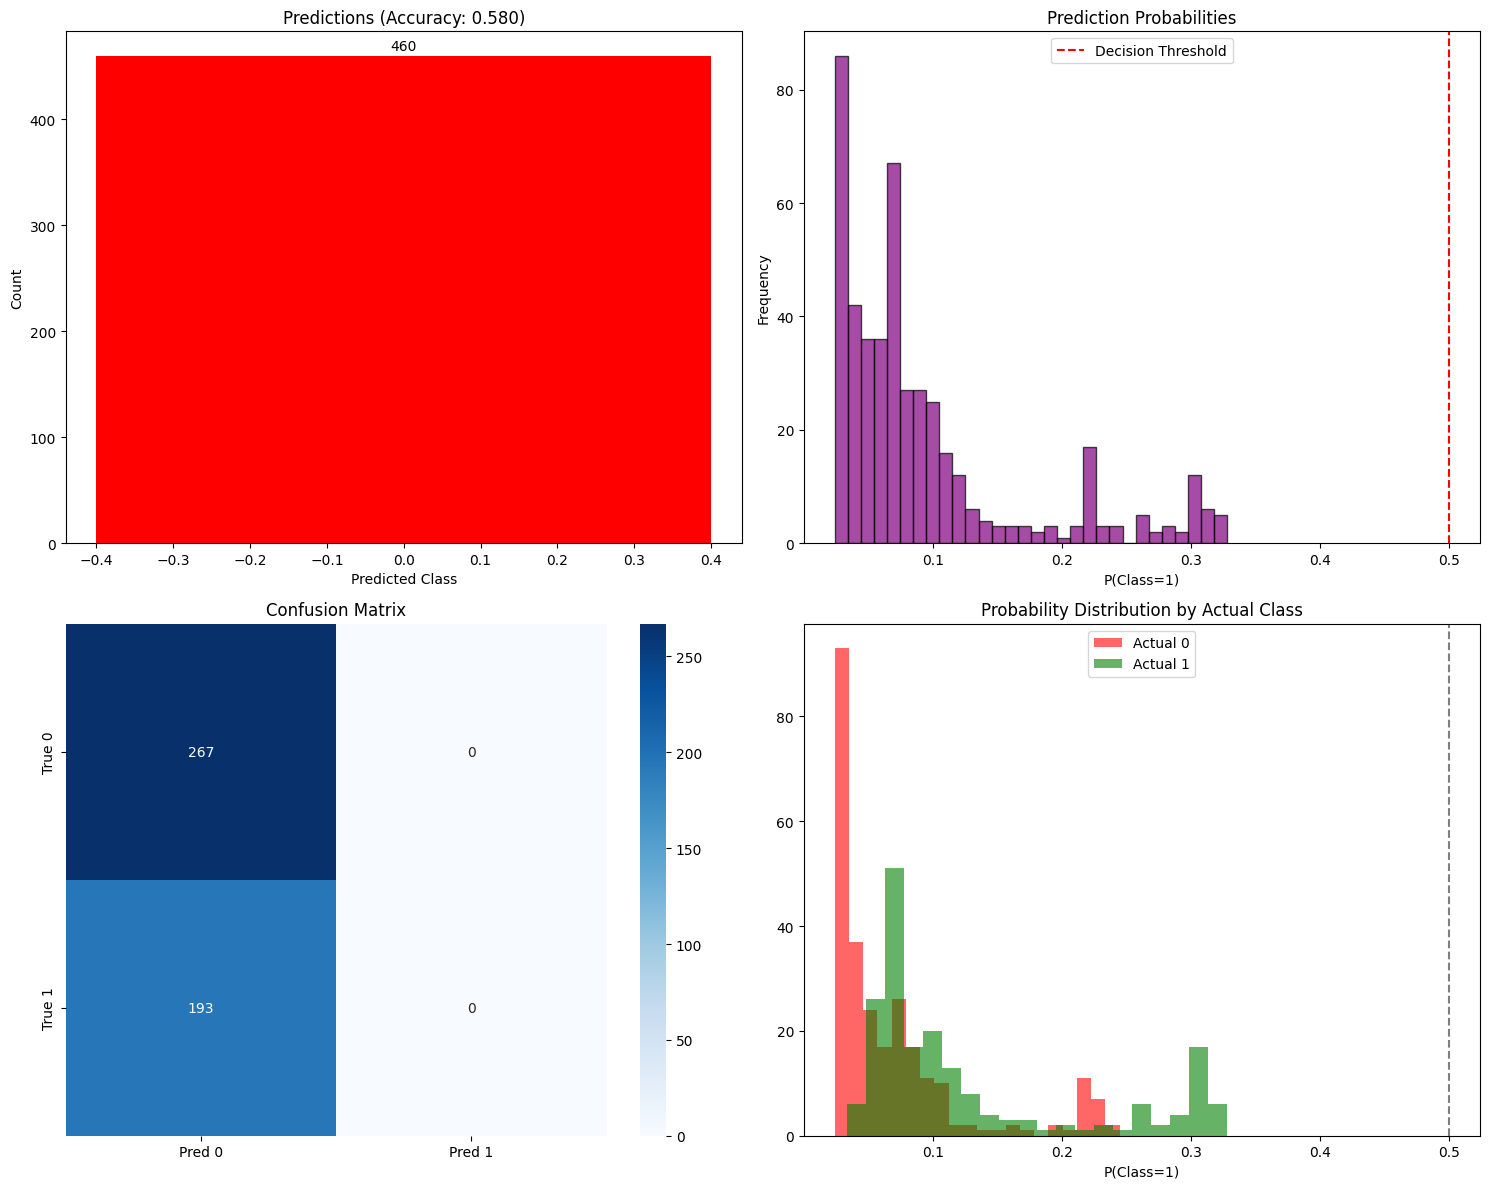

📊 CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Class 0 (Ned)       0.58      1.00      0.73       267
Class 1 (Upp)       0.00      0.00      0.00       193

     accuracy                           0.58       460
    macro avg       0.29      0.50      0.37       460
 weighted avg       0.34      0.58      0.43       460



In [7]:
# Visualisera model results
from sklearn.metrics import confusion_matrix, classification_report

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Prediction distribution
pred_counts = np.bincount(y_pred.astype(int))
axes[0,0].bar(range(len(pred_counts)), pred_counts, color=['red', 'green'])
axes[0,0].set_title(f'Predictions (Accuracy: {accuracy:.3f})')
axes[0,0].set_xlabel('Predicted Class')
axes[0,0].set_ylabel('Count')
for i, v in enumerate(pred_counts):
    axes[0,0].text(i, v + 5, str(v), ha='center')

# 2. Probability histogram
axes[0,1].hist(y_proba, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[0,1].set_title('Prediction Probabilities')
axes[0,1].set_xlabel('P(Class=1)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
axes[0,1].legend()

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues',
           xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
axes[1,0].set_title('Confusion Matrix')

# 4. Probability by actual class
for actual_class in [0, 1]:
    mask = (y_test == actual_class)
    class_proba = y_proba[mask]
    axes[1,1].hist(class_proba, alpha=0.6, bins=20,
                  label=f'Actual {actual_class}', 
                  color='red' if actual_class == 0 else 'green')
axes[1,1].legend()
axes[1,1].set_title('Probability Distribution by Actual Class')
axes[1,1].set_xlabel('P(Class=1)')
axes[1,1].axvline(0.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Classification report
print("📊 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Class 0 (Ned)', 'Class 1 (Upp)']))

## 6. Rolling Predictions Debug

In [8]:
# Debug rolling predictions
from src.train_predict import rolling_train_predict

print("🔄 ROLLING PREDICTIONS DEBUG")
print("=" * 40)

# Använd begränsad data för snabbare debug
max_rows = min(1000, len(df_clean))
df_rolling_sample = df_clean.head(max_rows).reset_index(drop=True)

print(f"📊 Rolling sample: {df_rolling_sample.shape}")

try:
    df_pred = rolling_train_predict(df_rolling_sample, feature_cols=feature_cols)
    
    print(f"✅ Rolling predictions klart!")
    print(f"  - Output shape: {df_pred.shape}")
    print(f"  - Nya kolumner: {set(df_pred.columns) - set(df_rolling_sample.columns)}")
    
    # Analysera predictions
    if 'pred' in df_pred.columns:
        pred_clean = df_pred.dropna(subset=['pred'])
        pred_counts = pred_clean['pred'].value_counts()
        print(f"  - Prediction distribution: {dict(pred_counts)}")
        print(f"  - Giltiga predictions: {len(pred_clean)} av {len(df_pred)}")
        
    if 'proba' in df_pred.columns:
        proba_clean = df_pred.dropna(subset=['proba'])
        if len(proba_clean) > 0:
            print(f"  - Probability stats: min={proba_clean['proba'].min():.3f}, "
                  f"max={proba_clean['proba'].max():.3f}, mean={proba_clean['proba'].mean():.3f}")
            
except Exception as e:
    print(f"❌ ERROR i rolling prediction: {e}")
    import traceback
    traceback.print_exc()

🔄 ROLLING PREDICTIONS DEBUG
📊 Rolling sample: (1000, 19)
✅ Rolling predictions klart!
  - Output shape: (1000, 21)
  - Nya kolumner: {'pred', 'proba'}
  - Prediction distribution: {0.0: np.int64(496), 1.0: np.int64(84)}
  - Giltiga predictions: 580 av 1000
  - Probability stats: min=0.042, max=0.829, mean=0.246


## 7. Interaktiv Feature Explorer

Kör cellerna nedan för att interaktivt utforska features:

In [9]:
# Funktion för att plotta enskilda features
def explore_feature(feature_name):
    """Utforska en specifik feature interaktivt."""
    if feature_name not in feature_cols:
        print(f"❌ Feature '{feature_name}' finns inte!")
        print(f"Tillgängliga: {feature_cols}")
        return
        
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Data prep
    data_clean = df_labeled.dropna(subset=[feature_name, 'label'])
    
    # 1. Time series
    axes[0].plot(range(len(data_clean)), data_clean[feature_name], linewidth=1)
    axes[0].set_title(f'{feature_name} Time Series')
    axes[0].set_xlabel('Time Index')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Distribution
    axes[1].hist(data_clean[feature_name], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].set_title(f'{feature_name} Distribution')
    axes[1].set_xlabel('Value')
    axes[1].grid(True, alpha=0.3)
    mean_val = data_clean[feature_name].mean()
    axes[1].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.3f}')
    axes[1].legend()
    
    # 3. By Label
    for label in [0, 1]:
        label_data = data_clean[data_clean['label'] == label][feature_name]
        axes[2].hist(label_data, alpha=0.6, bins=20,
                    label=f'Label {label} (n={len(label_data)})', 
                    color='red' if label == 0 else 'green')
    axes[2].legend()
    axes[2].set_title(f'{feature_name} by Label')
    axes[2].set_xlabel('Value')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistik
    print(f"📊 {feature_name} Statistik:")
    for label in [0, 1]:
        label_data = data_clean[data_clean['label'] == label][feature_name]
        print(f"  Label {label}: mean={label_data.mean():.4f}, std={label_data.std():.4f}, n={len(label_data)}")

# Lista alla tillgängliga features
print("🔍 TILLGÄNGLIGA FEATURES FÖR EXPLORATION:")
for i, feat in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feat}")

🔍 TILLGÄNGLIGA FEATURES FÖR EXPLORATION:
 1. RTF_70_slope
 2. SMA_30_avg
 3. SMA_30_min
 4. SMA_100_avg
 5. SMA_100_min
 6. SMA_150_avg
 7. SMA_150_min
 8. MomEma_150_15
 9. MomEma_70_15
10. MomEma_100_15
11. MomTema_300_15
12. RCTema_200
13. RCTema_100
14. LogReturn_30


🎨 AUTOMATISK EXPLORATION AV ALLA FEATURES

📊 Feature 1/14: RTF_70_slope
----------------------------------------


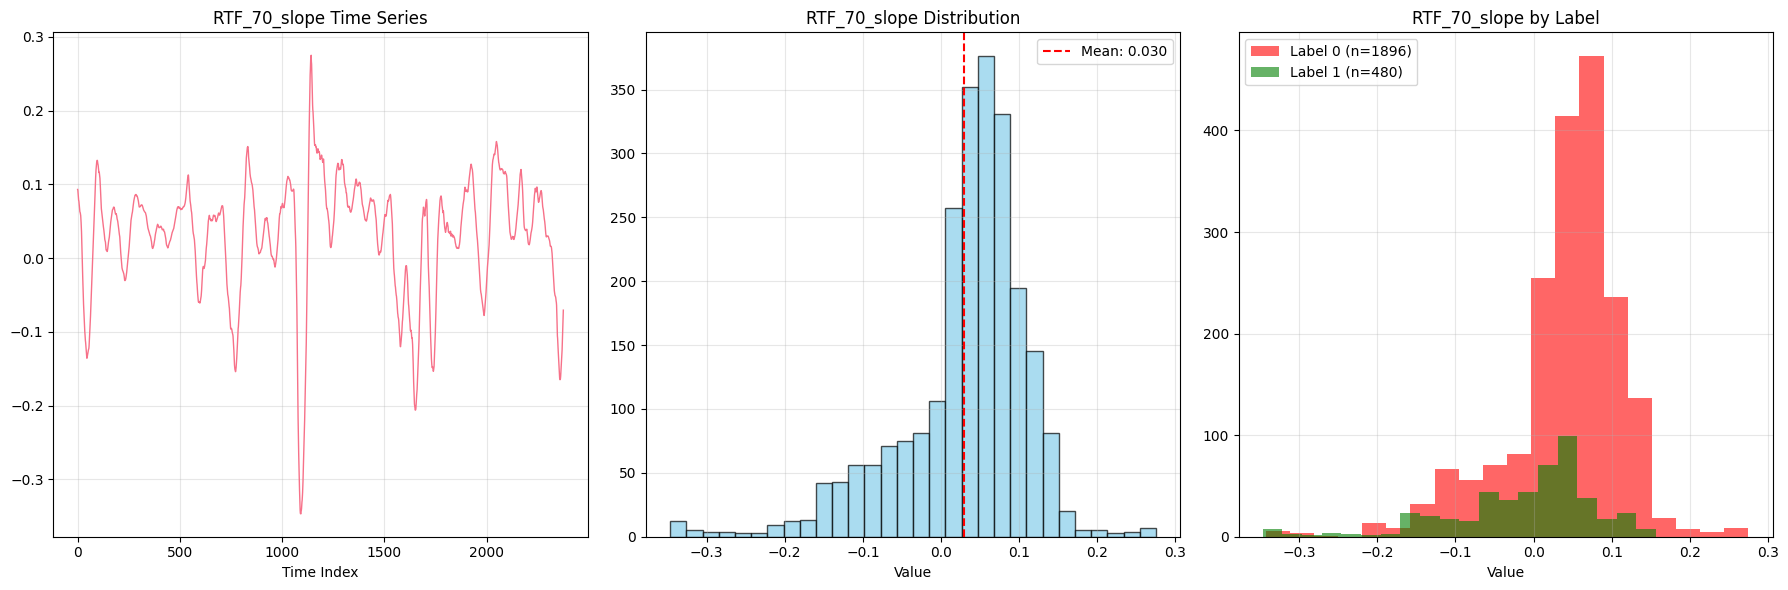

📊 RTF_70_slope Statistik:
  Label 0: mean=0.0409, std=0.0756, n=1896
  Label 1: mean=-0.0136, std=0.0949, n=480


📊 Feature 2/14: SMA_30_avg
----------------------------------------


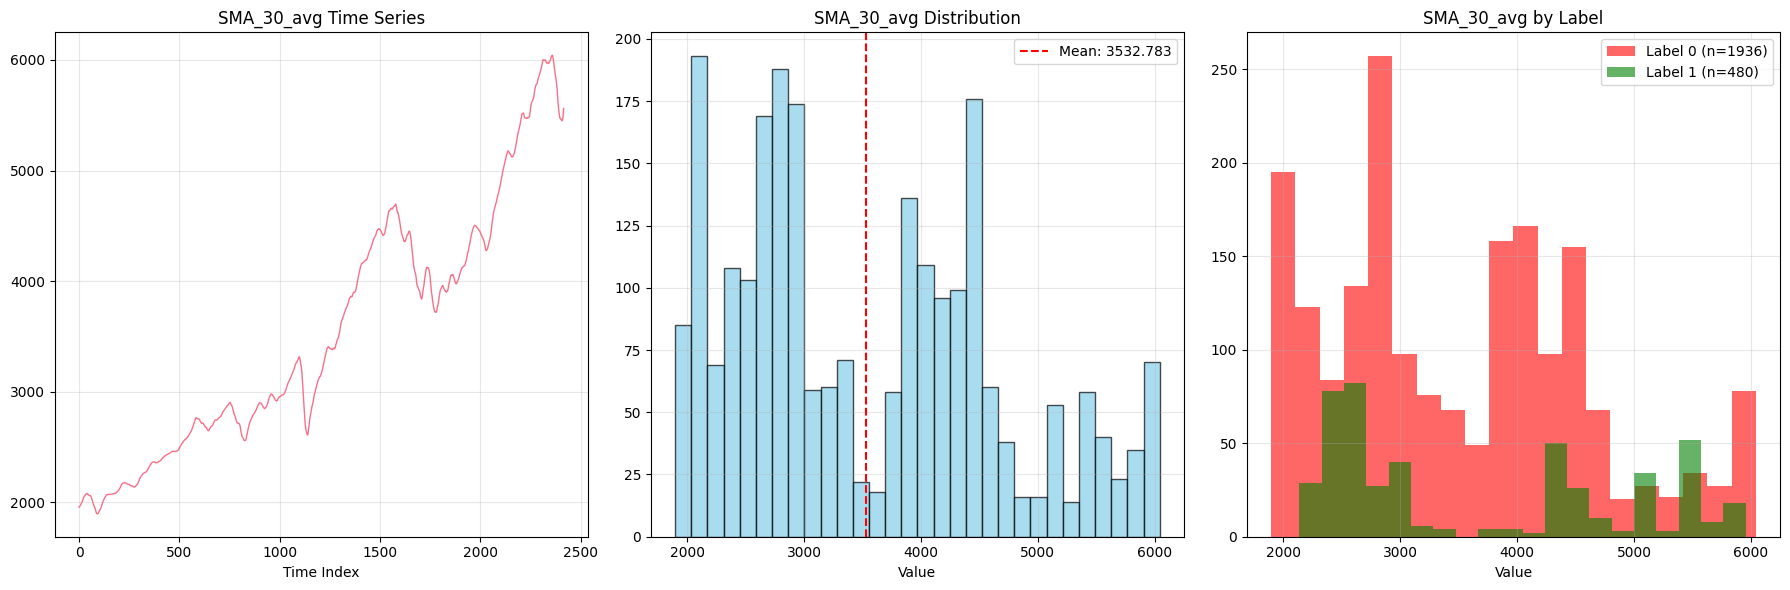

📊 SMA_30_avg Statistik:
  Label 0: mean=3501.6672, std=1087.6799, n=1936
  Label 1: mean=3658.2818, std=1243.3484, n=480


📊 Feature 3/14: SMA_30_min
----------------------------------------


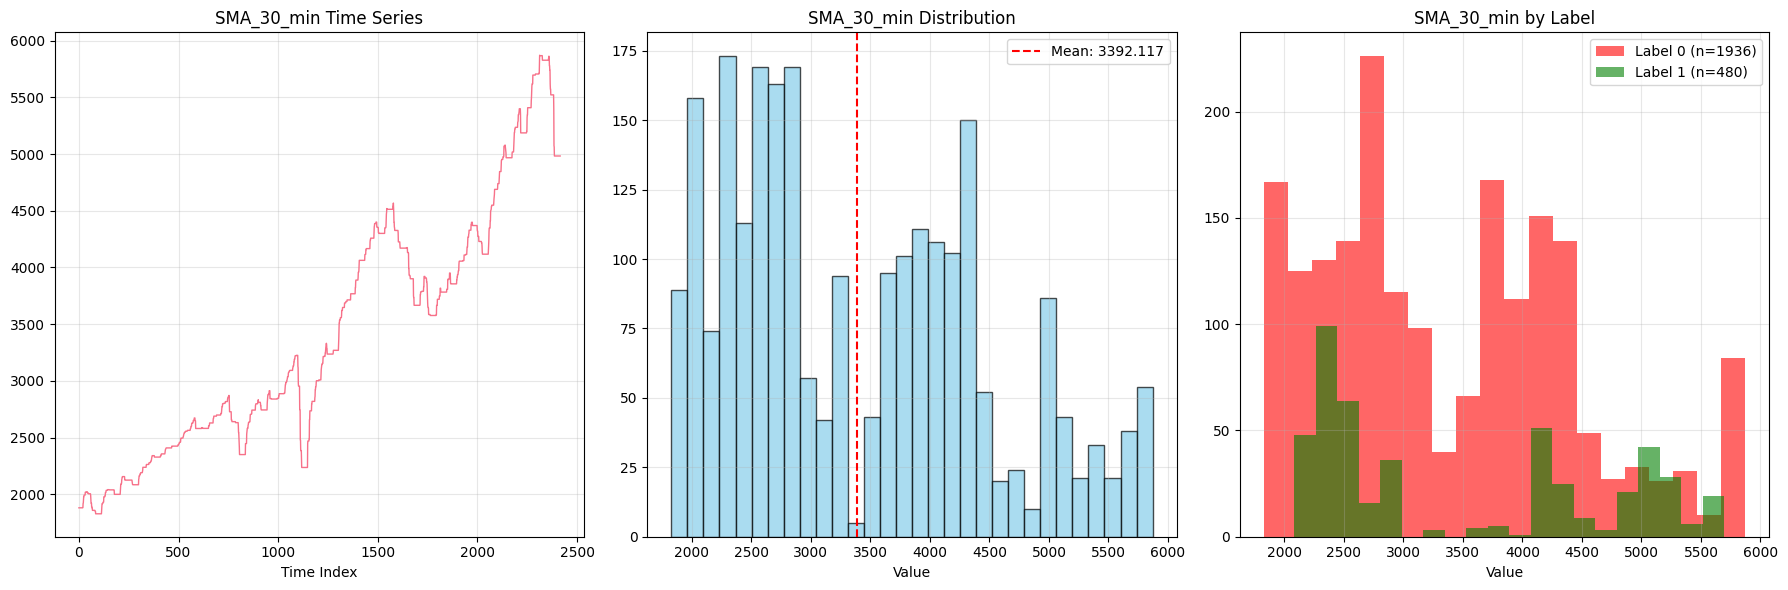

📊 SMA_30_min Statistik:
  Label 0: mean=3371.3095, std=1048.5951, n=1936
  Label 1: mean=3476.0396, std=1181.0068, n=480


📊 Feature 4/14: SMA_100_avg
----------------------------------------


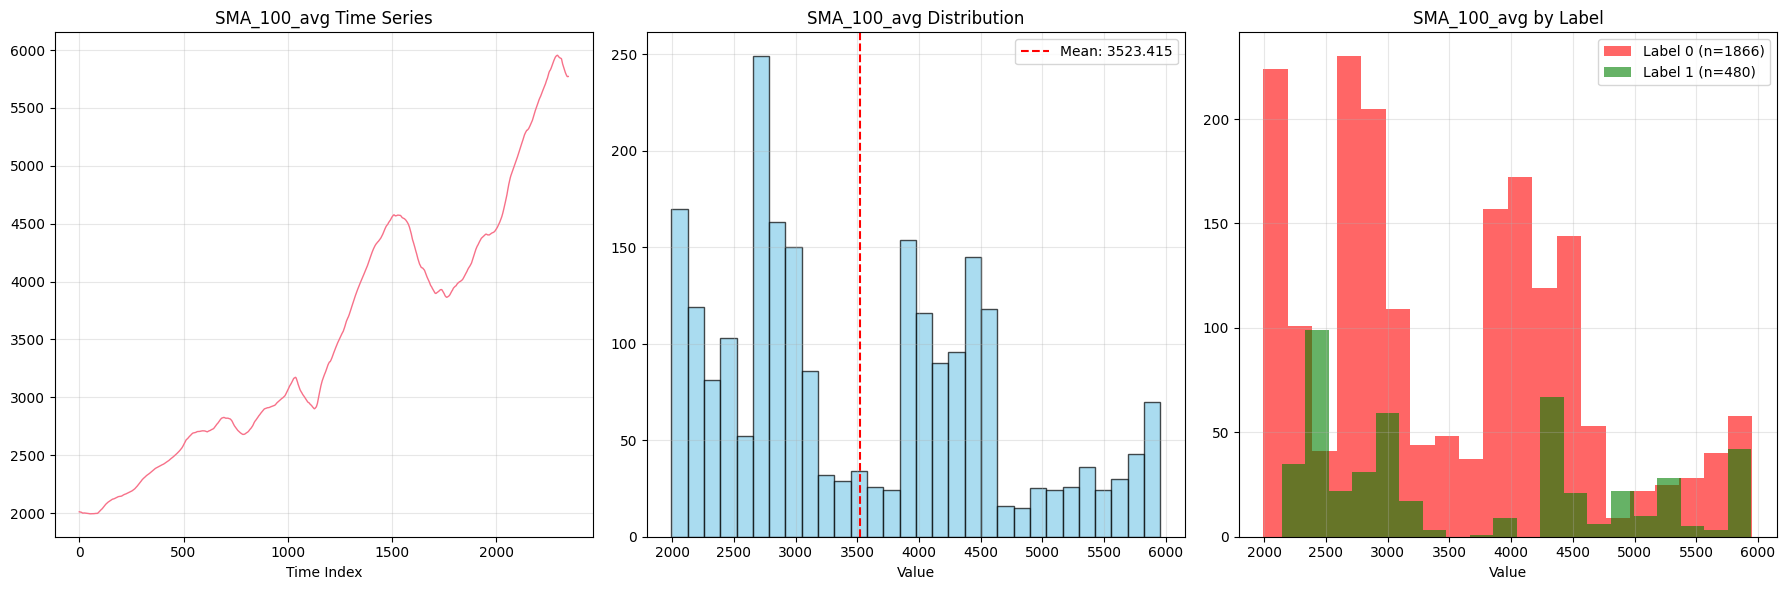

📊 SMA_100_avg Statistik:
  Label 0: mean=3488.8285, std=1043.9088, n=1866
  Label 1: mean=3657.8683, std=1228.8087, n=480


📊 Feature 5/14: SMA_100_min
----------------------------------------


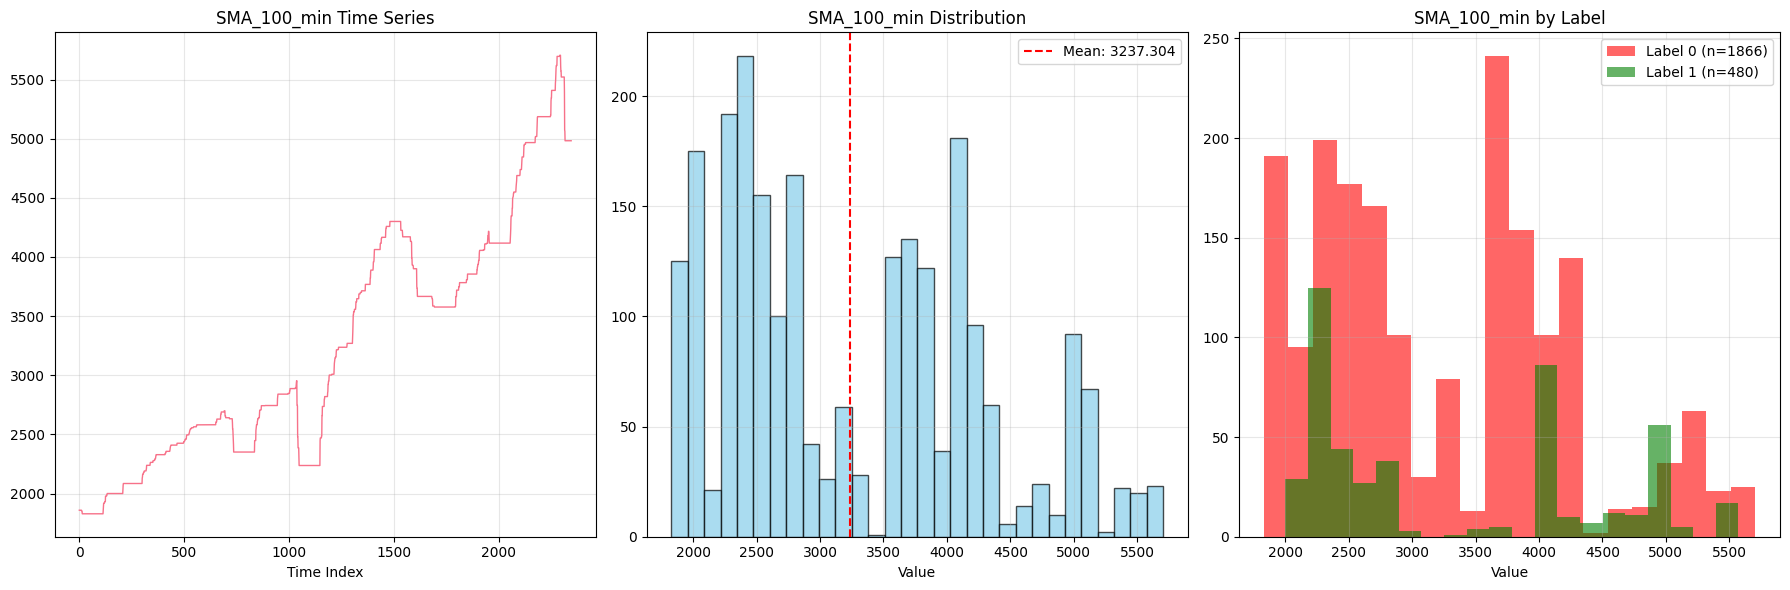

📊 SMA_100_min Statistik:
  Label 0: mean=3210.1661, std=977.8603, n=1866
  Label 1: mean=3342.8031, std=1120.3854, n=480


📊 Feature 6/14: SMA_150_avg
----------------------------------------


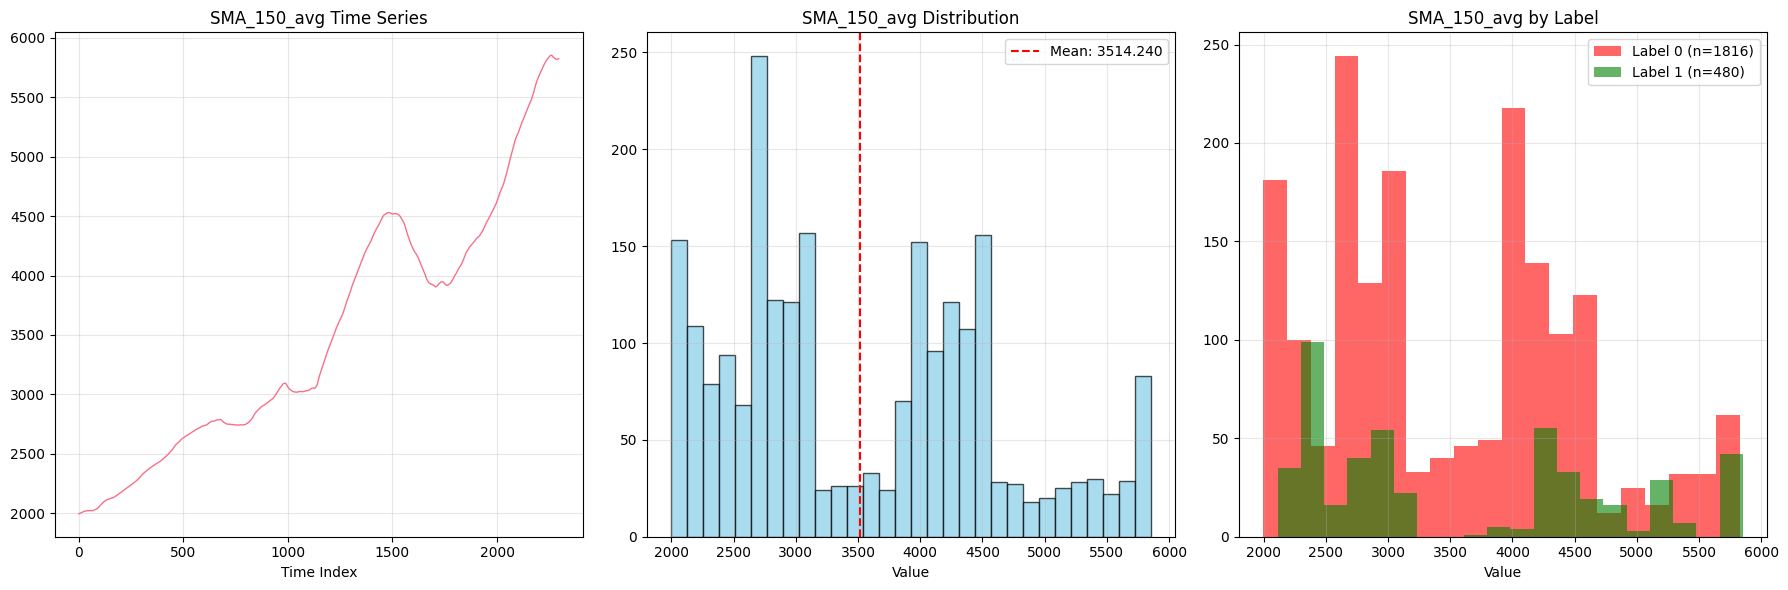

📊 SMA_150_avg Statistik:
  Label 0: mean=3490.1298, std=1008.1814, n=1816
  Label 1: mean=3605.4570, std=1202.8234, n=480


📊 Feature 7/14: SMA_150_min
----------------------------------------


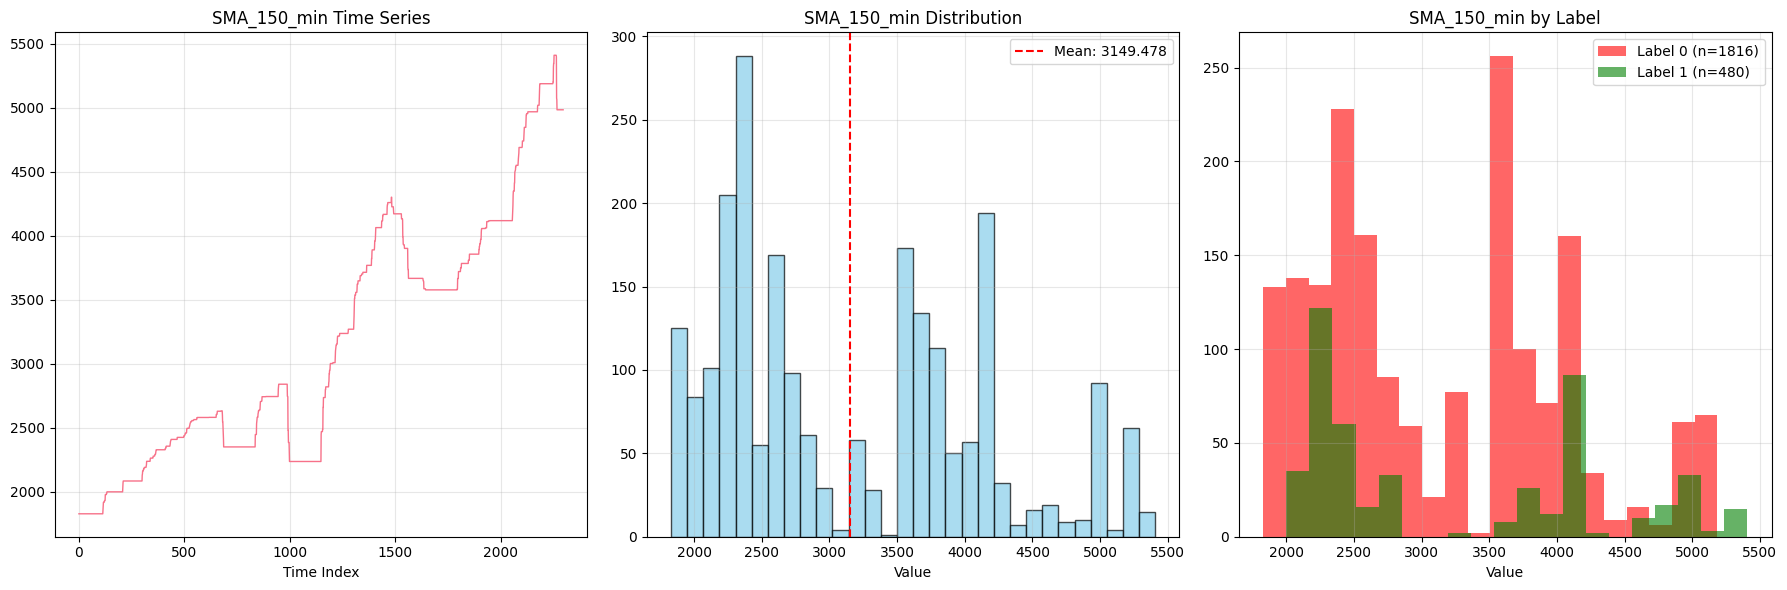

📊 SMA_150_min Statistik:
  Label 0: mean=3125.1987, std=927.4085, n=1816
  Label 1: mean=3241.3329, std=1070.1321, n=480


📊 Feature 8/14: MomEma_150_15
----------------------------------------


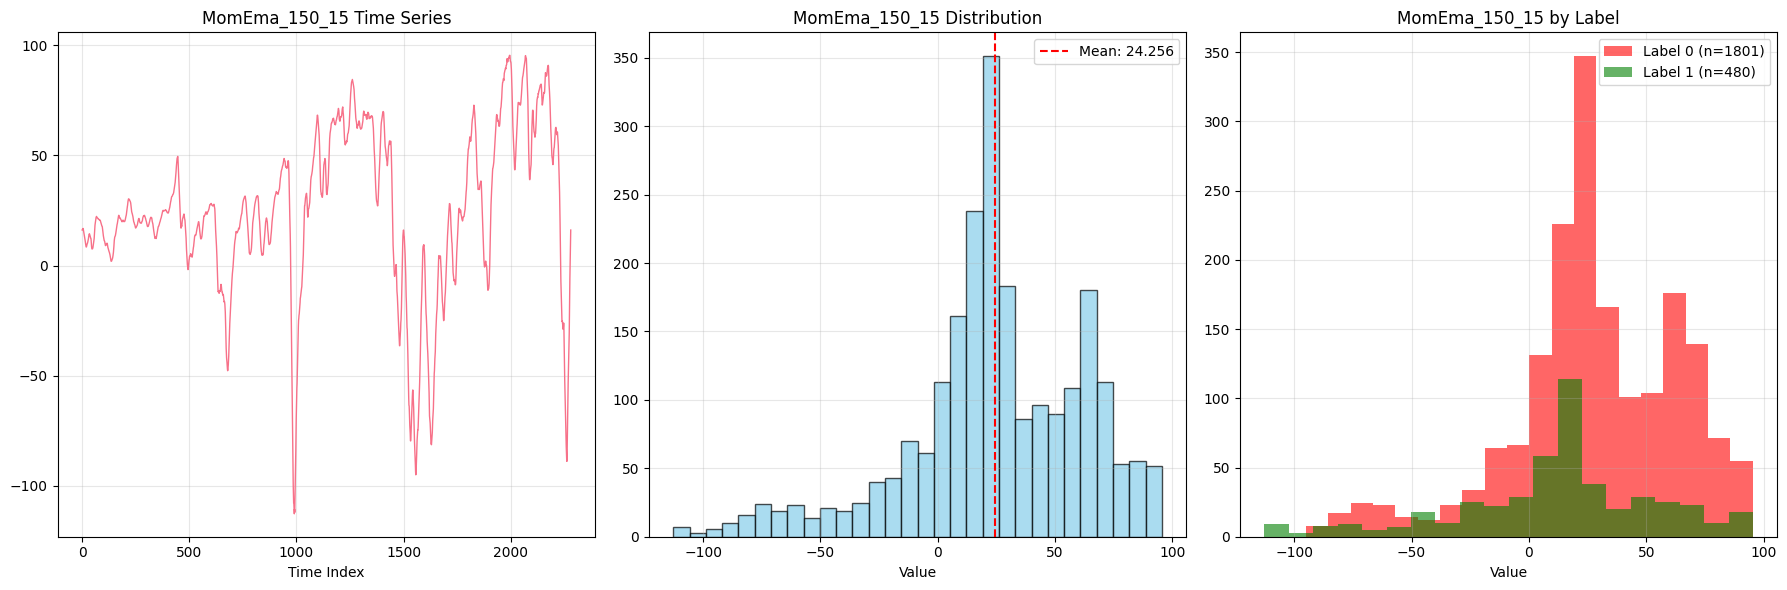

📊 MomEma_150_15 Statistik:
  Label 0: mean=27.6653, std=35.8948, n=1801
  Label 1: mean=11.4626, std=42.5831, n=480


📊 Feature 9/14: MomEma_70_15
----------------------------------------


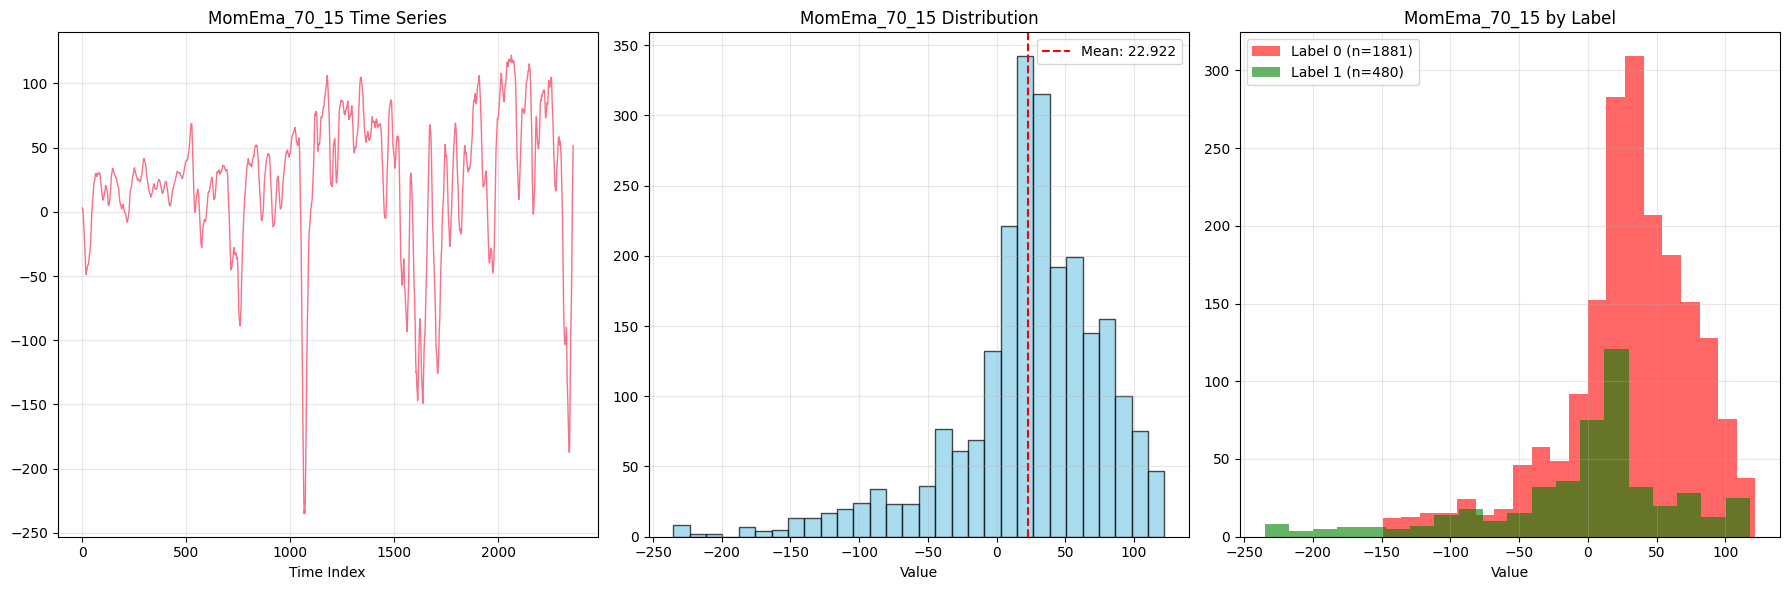

📊 MomEma_70_15 Statistik:
  Label 0: mean=29.7538, std=48.4011, n=1881
  Label 1: mean=-3.8500, std=71.1560, n=480


📊 Feature 10/14: MomEma_100_15
----------------------------------------


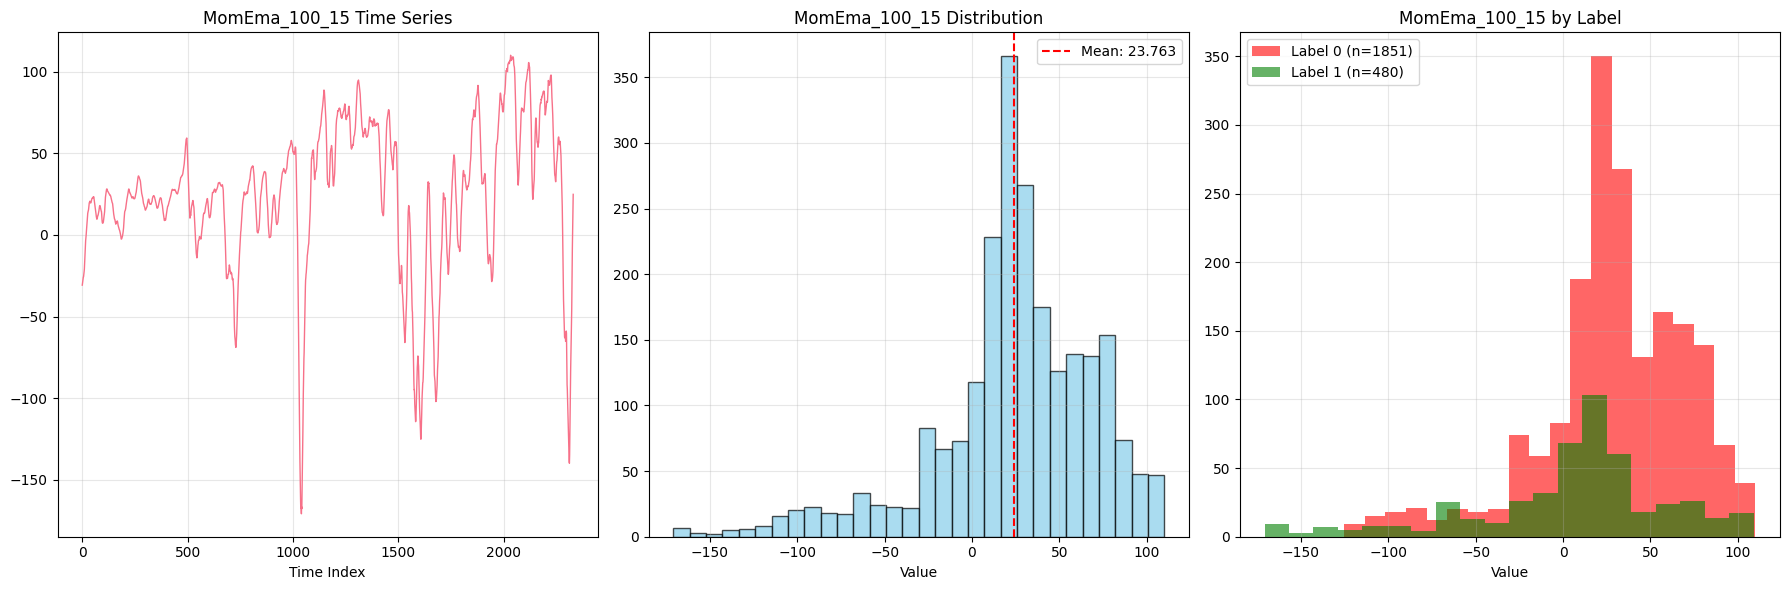

📊 MomEma_100_15 Statistik:
  Label 0: mean=28.8993, std=41.9262, n=1851
  Label 1: mean=3.9562, std=56.4089, n=480


📊 Feature 11/14: MomTema_300_15
----------------------------------------


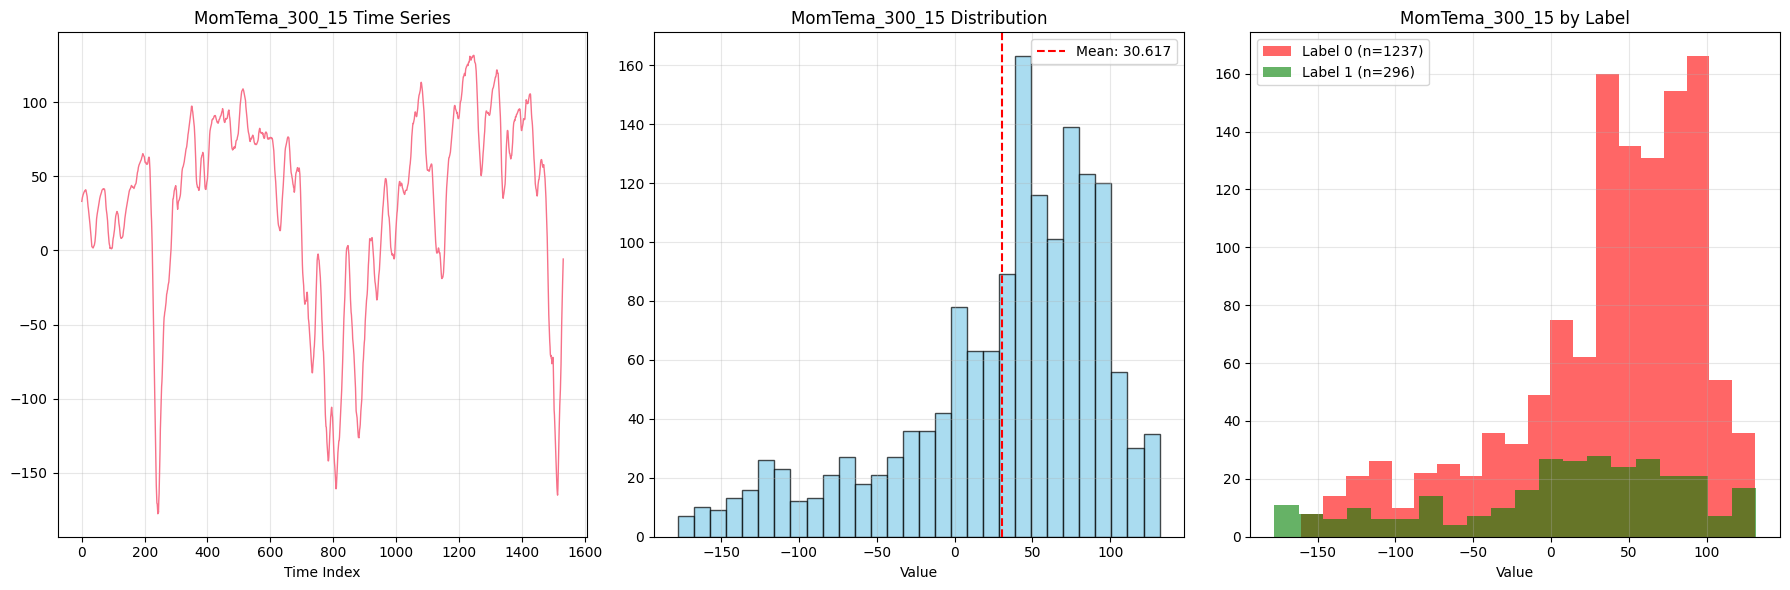

📊 MomTema_300_15 Statistik:
  Label 0: mean=36.2510, std=61.4532, n=1237
  Label 1: mean=7.0708, std=79.4899, n=296


📊 Feature 12/14: RCTema_200
----------------------------------------


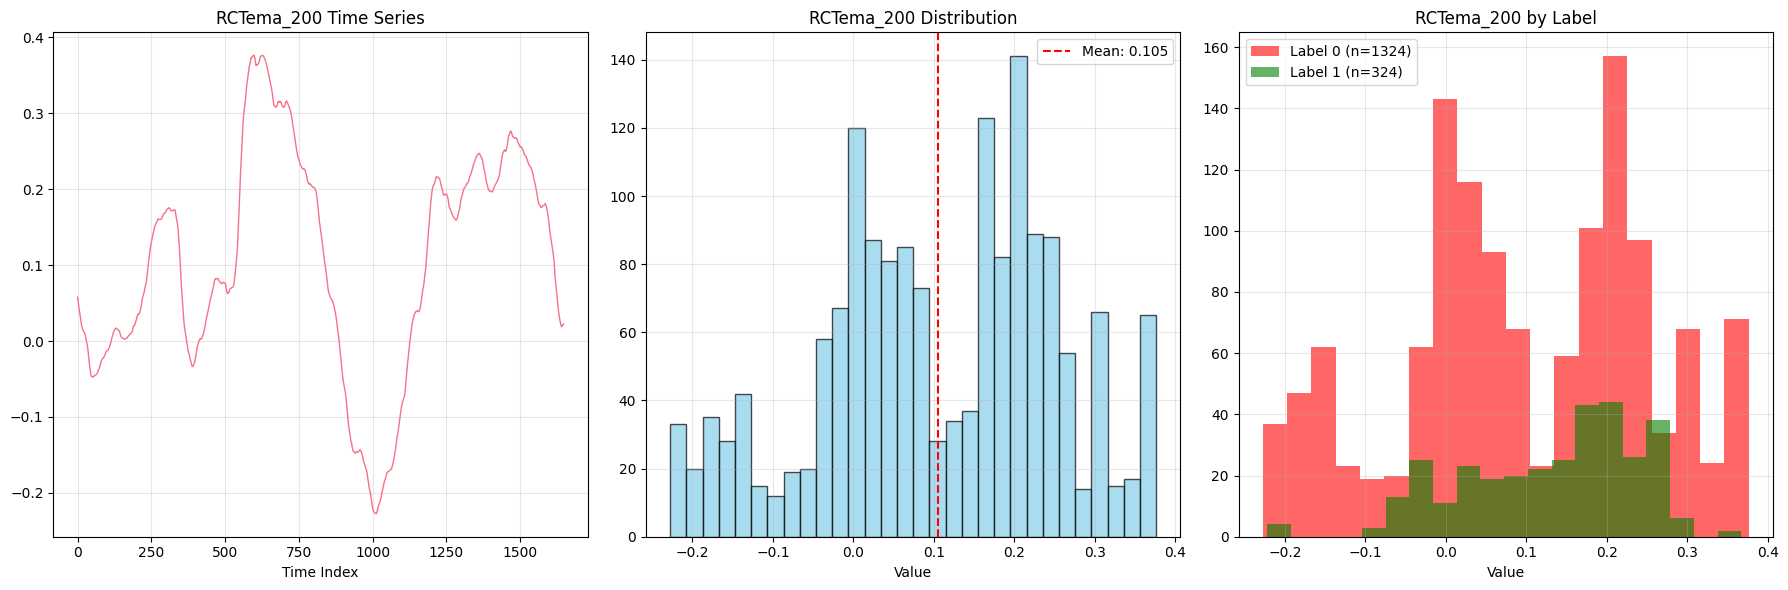

📊 RCTema_200 Statistik:
  Label 0: mean=0.0991, std=0.1546, n=1324
  Label 1: mean=0.1301, std=0.1086, n=324


📊 Feature 13/14: RCTema_100
----------------------------------------


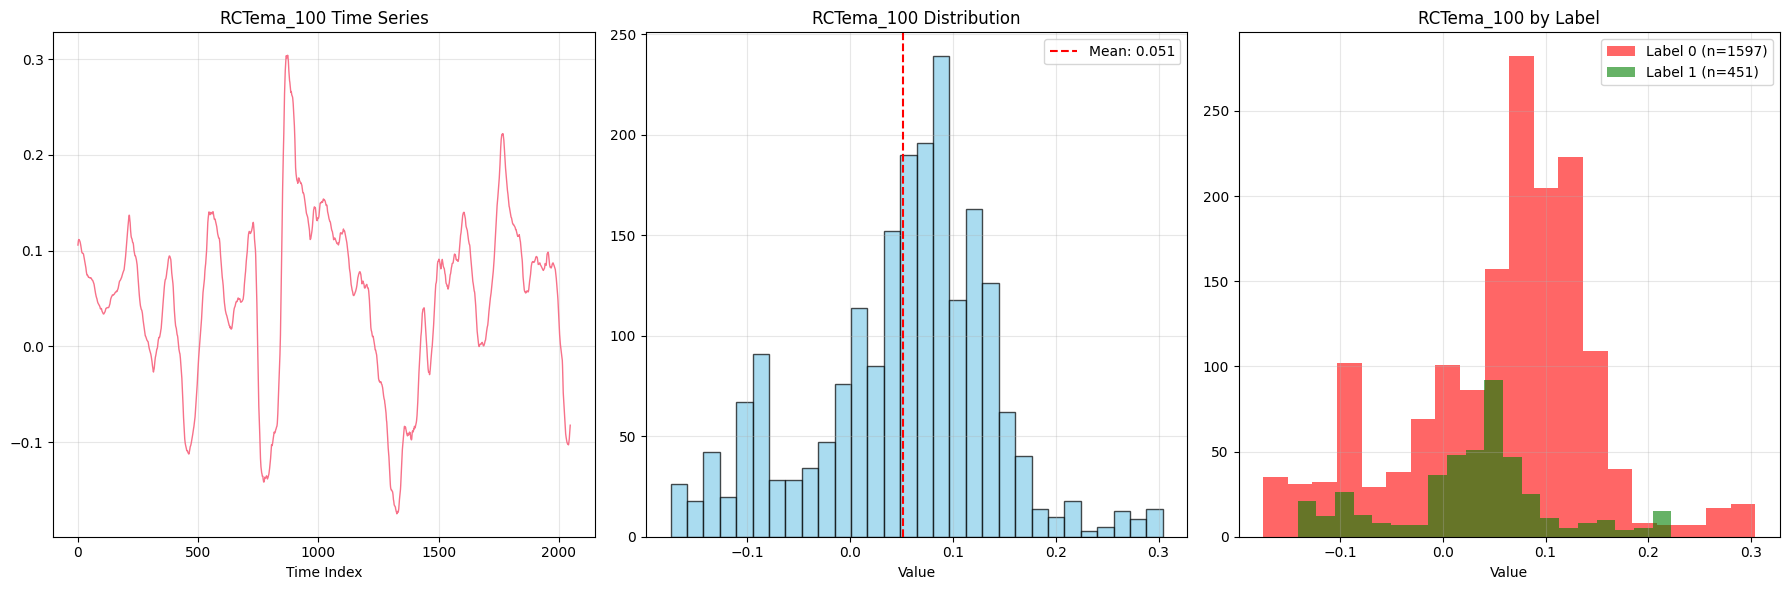

📊 RCTema_100 Statistik:
  Label 0: mean=0.0573, std=0.0900, n=1597
  Label 1: mean=0.0291, std=0.0796, n=451


📊 Feature 14/14: LogReturn_30
----------------------------------------


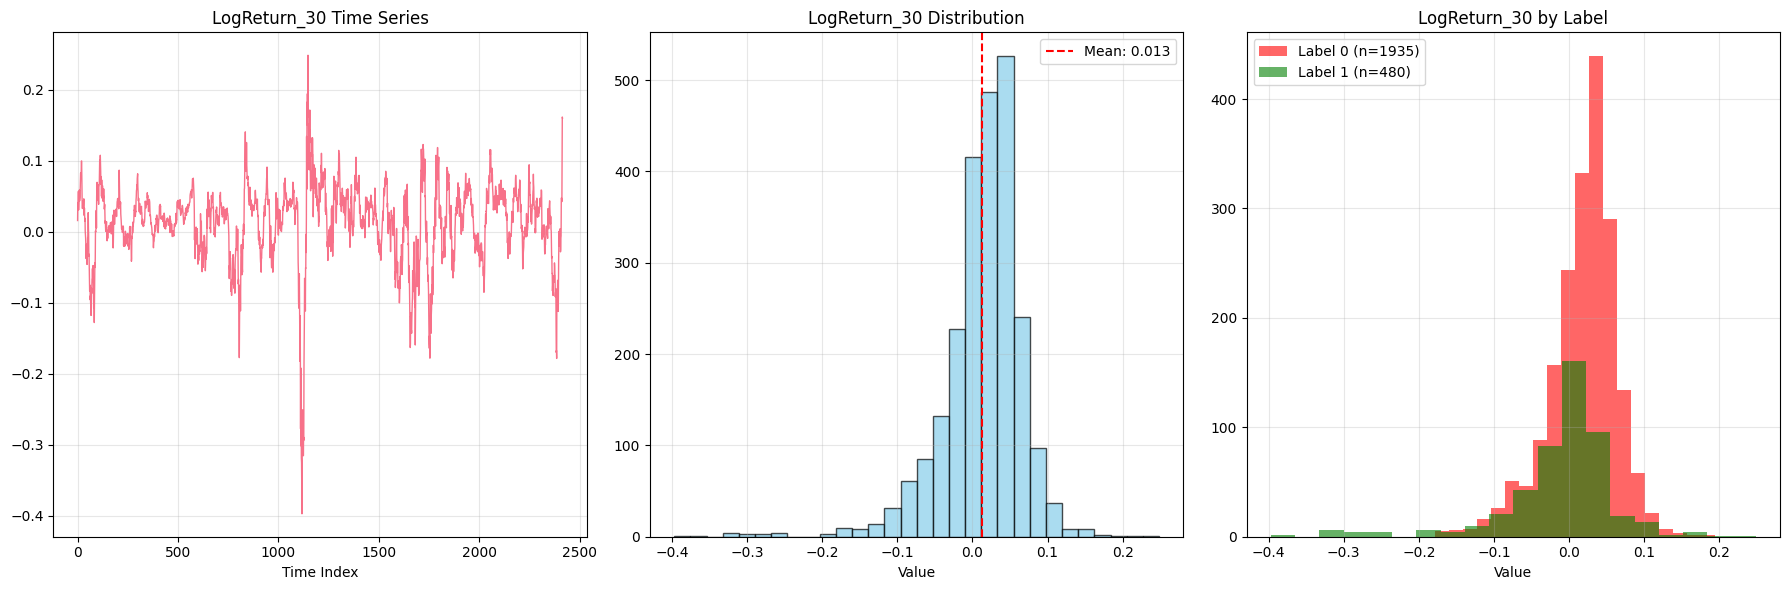

📊 LogReturn_30 Statistik:
  Label 0: mean=0.0192, std=0.0458, n=1935
  Label 1: mean=-0.0121, std=0.0769, n=480


✅ Alla 14 features utforskade!


In [11]:
# Utforska ALLA features automatiskt
print("🎨 AUTOMATISK EXPLORATION AV ALLA FEATURES")
print("=" * 50)

for i, feature_name in enumerate(feature_cols, 1):
    print(f"\n📊 Feature {i}/{len(feature_cols)}: {feature_name}")
    print("-" * 40)
    
    # Använd den befintliga explore_feature funktionen
    explore_feature(feature_name)
    
    # Lägg till separator mellan features
    print("\n" + "="*50)

print(f"\n✅ Alla {len(feature_cols)} features utforskade!")

## 8. Sammanfattning och Nästa Steg

Detta notebook ger dig kraftfulla verktyg för ML-debugging:

### ✅ Vad vi kontrollerat:
- **Data kvalitet**: shapes, NaN-mönster, distributions
- **Feature analys**: statistik, korrelationer, outliers  
- **ML training**: model performance, predictions, probabilities
- **Rolling predictions**: pipeline funktionalitet

### 🔧 Debug-verktyg du nu har:
1. **Visualiseringar** istället för konsol-utskrifter
2. **Interaktiv feature exploration** 
3. **Model performance analysis**
4. **Data quality checks**

### 📈 Nästa steg:
1. Kör `explore_feature()` för olika features
2. Experimentera med andra model parameters
3. Analysera feature importance
4. Testa olika time windows för rolling predictions